In [43]:
import pandas as pd
import numpy as np 
import itertools
import keras
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras import Sequential
from keras import optimizers
from keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

In [44]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir =  'DATASET/train'
validation_data_dir = 'DATASET/validation'
   
# number of epochs to train top model  
epochs = 10 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 64

In [45]:
IMG_SHAPE = (img_width, img_height, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, 
    include_top=False, 
    weights='imagenet'
)

In [46]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files


In [47]:
base_model.trainable = False

In [48]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = base_model.predict(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 240 images belonging to 3 classes.
Time:  0:00:04.966160


In [49]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = base_model.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 60 images belonging to 3 classes.


/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:00:01.618330


In [50]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 240 images belonging to 3 classes.


In [51]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 60 images belonging to 3 classes.


In [52]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()


# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.MaxPooling2D(strides=1),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(3, activation='softmax')

# ])

model = Sequential()
base_model,
model.add(Conv2D(32, 3, activation='relu')),
model.add(Dropout(0.2)),
model.add(MaxPooling2D(strides=1)),
model.add(Flatten()),
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics='accuracy')
             


In [53]:

history = model.fit(train_data, train_labels,  
      epochs=epochs,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/10
4/4 [==============================] - 1s 84ms/step - loss: 9.1181 - accuracy: 0.3917 - val_loss: 3.7774 - val_accuracy: 0.3333
Epoch 2/10
4/4 [==============================] - 0s 43ms/step - loss: 1.4196 - accuracy: 0.5042 - val_loss: 1.0673 - val_accuracy: 0.4667
Epoch 3/10
4/4 [==============================] - 0s 45ms/step - loss: 0.8139 - accuracy: 0.6417 - val_loss: 1.0413 - val_accuracy: 0.4333
Epoch 4/10
4/4 [==============================] - 0s 43ms/step - loss: 0.6811 - accuracy: 0.7333 - val_loss: 1.0375 - val_accuracy: 0.4667
Epoch 5/10
4/4 [==============================] - 0s 49ms/step - loss: 0.5874 - accuracy: 0.7583 - val_loss: 1.0060 - val_accuracy: 0.5167
Epoch 6/10
4/4 [==============================] - 0s 47ms/step - loss: 0.4676 - accuracy: 0.8417 - val_loss: 1.0013 - val_accuracy: 0.4833
Epoch 7/10
4/4 [==============================] - 0s 44ms/step - loss: 0.3945 - accuracy: 0.8750 - val_loss: 0.9797 - val_accuracy: 0.5167
Epoch 8/10
4/4 [===========

In [54]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 370,211
Trainable params: 370,211
Non-trainable params: 0
_________________________________________________________________


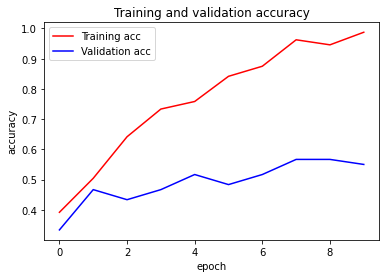

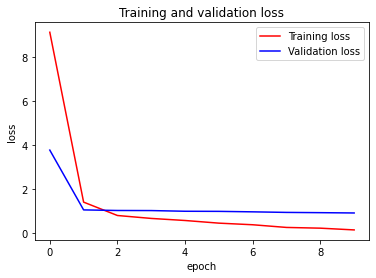

In [55]:
#Graphing our training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [56]:
model.evaluate(validation_data, validation_labels)


2/2 [==============================] - 0s 9ms/step - loss: 0.9284 - accuracy: 0.5500


[0.9283944368362427, 0.550000011920929]

In [57]:
# print('test data', validation_data)
preds = np.round(model.predict(validation_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
# print('rounded test_labels', preds)

In [58]:
animals = ['PSORIASIS', 'RINGWORM', 'SCABIES']
classification_metrics = metrics.classification_report(validation_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

   PSORIASIS       0.48      0.55      0.51        20
    RINGWORM       0.60      0.45      0.51        20
     SCABIES       0.77      0.50      0.61        20

   micro avg       0.59      0.50      0.54        60
   macro avg       0.62      0.50      0.54        60
weighted avg       0.62      0.50      0.54        60
 samples avg       0.50      0.50      0.50        60



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_validation_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [60]:
confusion_matrix= confusion_matrix(categorical_validation_labels, categorical_preds)


In [61]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


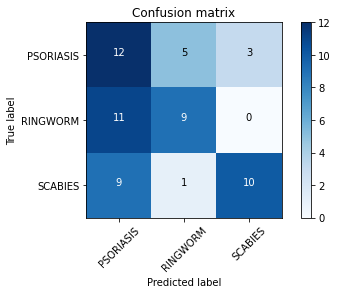

In [62]:
plot_confusion_matrix(confusion_matrix, ['PSORIASIS', 'RINGWORM', 'SCABIES'])


Normalized confusion matrix


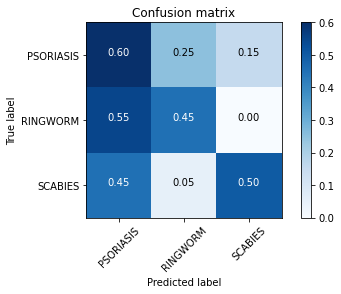

In [63]:
plot_confusion_matrix(confusion_matrix, ['PSORIASIS', 'RINGWORM', 'SCABIES'], normalize=True)
